# Simple Text Generation from Scratch (Mini Decoder-Only Model)

This notebook builds a tiny decoder-only language model to understand how LLMs generate text token by token.

The goal is not to get a powerful model, but to see the full pipeline end to end on a small toy example:

1. Create a tiny vocabulary and tokenizer  
2. Build training sequences for next-token prediction  
3. Implement a minimal Transformer-style decoder block in PyTorch  
4. Train it on a tiny corpus  
5. Generate text with different temperatures using autoregressive decoding

This connects the other notebooks in this repo (attention, sparse attention, MoE, RLHF) to the final step:  
how a model actually generates a sequence of tokens.


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import random
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [10]:
# Tiny toy corpus  short, simple sentences
corpus = [
    "i like machine learning",
    "i like deep learning",
    "you like neural networks",
    "we study machine learning",
    "we study deep networks",
    "i love learning new models",
    "you love deep models",
    "we build simple transformers",
]

# Special tokens
PAD = "<pad>"
BOS = "<bos>"
EOS = "<eos>"

# Build vocabulary from corpus words
words = set()
for sent in corpus:
    for w in sent.split():
        words.add(w)

# Make sure it is deterministic
words = sorted(list(words))

itos = [PAD, BOS, EOS] + words  # index -> token
stoi = {tok: idx for idx, tok in enumerate(itos)}

vocab_size = len(itos)
vocab_size, itos

(19,
 ['<pad>',
  '<bos>',
  '<eos>',
  'build',
  'deep',
  'i',
  'learning',
  'like',
  'love',
  'machine',
  'models',
  'networks',
  'neural',
  'new',
  'simple',
  'study',
  'transformers',
  'we',
  'you'])

In [11]:
def encode_sentence(text, max_len=10):
    """
    Convert a sentence string into a list of token IDs:
    [BOS, ..., EOS, PAD, PAD, ...]
    """
    tokens = text.split()
    ids = [stoi[BOS]] + [stoi[w] for w in tokens] + [stoi[EOS]]
    # pad / truncate
    ids = ids[:max_len]
    ids = ids + [stoi[PAD]] * (max_len - len(ids))
    return torch.tensor(ids, dtype=torch.long)

def decode_tokens(ids):
    """
    Turn a list/tensor of IDs back into a string, 
    stopping at EOS and skipping PAD/BOS.
    """
    tokens = []
    for i in ids:
        tok = itos[int(i)]
        if tok == EOS:
            break
        if tok in (PAD, BOS):
            continue
        tokens.append(tok)
    return " ".join(tokens)

# Quick sanity check
encode_sentence("i like machine learning"), decode_tokens(encode_sentence("i like machine learning"))

(tensor([1, 5, 7, 9, 6, 2, 0, 0, 0, 0]), 'i like machine learning')

In [12]:
max_len = 10

encoded = [encode_sentence(s, max_len=max_len) for s in corpus]
data = torch.stack(encoded)  # shape: (num_sentences, max_len)

# For next-token prediction:
# input = all tokens except last
# target = all tokens except first
inputs = data[:, :-1]   # (N, T-1)
targets = data[:, 1:]   # (N, T-1)

inputs.shape, targets.shape

(torch.Size([8, 9]), torch.Size([8, 9]))

In [13]:
class MiniDecoder(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, num_heads=1, ff_dim=128, max_len=16):
        super().__init__()
        self.embed_dim = embed_dim
        
        # Token + positional embeddings
        self.token_emb = nn.Embedding(vocab_size, embed_dim)
        self.pos_emb = nn.Embedding(max_len, embed_dim)
        
        # Self-attention
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        
        # Feed-forward block
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim),
        )
        
        # Layer norms
        self.ln1 = nn.LayerNorm(embed_dim)
        self.ln2 = nn.LayerNorm(embed_dim)
        
        # Final output layer (to vocab logits)
        self.out = nn.Linear(embed_dim, vocab_size)
    
    def forward(self, x):
        """
        x: (batch, seq_len) of token IDs
        """
        batch_size, seq_len = x.shape
        
        # Token + positional embeddings
        tok = self.token_emb(x)  # (B, T, D)
        positions = torch.arange(seq_len, device=x.device)
        pos = self.pos_emb(positions)[None, :, :]  # (1, T, D)
        h = tok + pos
        
        # Causal mask so each position only attends to previous + itself
        # attn_mask shape for batch_first=True is (T, T)
        causal_mask = torch.triu(torch.ones(seq_len, seq_len, device=x.device) * float("-inf"), diagonal=1)
        
        # Self-attention (MultiheadAttention expects (B, T, D) here because batch_first=True)
        attn_out, _ = self.attn(h, h, h, attn_mask=causal_mask)
        h = self.ln1(h + attn_out)
        
        # Feed-forward
        ff_out = self.ff(h)
        h = self.ln2(h + ff_out)
        
        # Project to vocab
        logits = self.out(h)  # (B, T, vocab_size)
        return logits

model = MiniDecoder(vocab_size=vocab_size, embed_dim=64, max_len=max_len).to(device)
model

MiniDecoder(
  (token_emb): Embedding(19, 64)
  (pos_emb): Embedding(10, 64)
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
  )
  (ff): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
  )
  (ln1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (ln2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (out): Linear(in_features=64, out_features=19, bias=True)
)

Epoch   50 / 400, loss = 0.5966
Epoch  100 / 400, loss = 0.5127
Epoch  150 / 400, loss = 0.5002
Epoch  200 / 400, loss = 0.4952
Epoch  250 / 400, loss = 0.4925
Epoch  300 / 400, loss = 0.4909
Epoch  350 / 400, loss = 0.4463
Epoch  400 / 400, loss = 0.4095


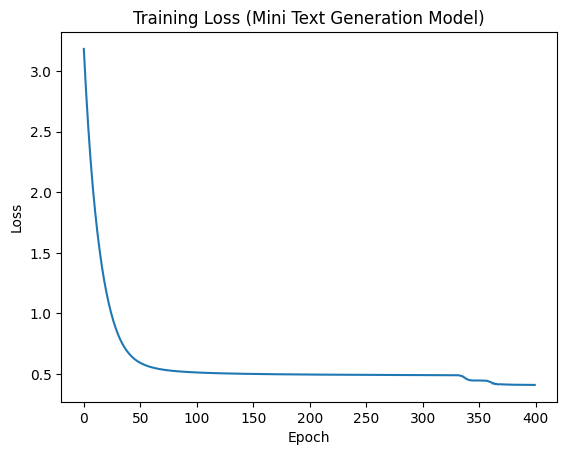

In [14]:
batch_inputs = inputs.to(device)
batch_targets = targets.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss(ignore_index=stoi[PAD])

num_epochs = 400
loss_history = []

for epoch in range(1, num_epochs + 1):
    model.train()
    optimizer.zero_grad()
    
    logits = model(batch_inputs)  # (N, T, V)
    # reshape for CrossEntropy: (N*T, V) vs (N*T,)
    N, T, V = logits.shape
    loss = loss_fn(logits.view(N * T, V), batch_targets.reshape(N * T))
    
    loss.backward()
    optimizer.step()
    
    loss_history.append(loss.item())
    
    if epoch % 50 == 0:
        print(f"Epoch {epoch:4d} / {num_epochs}, loss = {loss.item():.4f}")

# Plot loss curve
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss (Mini Text Generation Model)")
plt.show()

In [15]:
@torch.no_grad()
def generate_text(prompt, max_new_tokens=8, temperature=1.0):
    """
    Autoregressive generation with temperature sampling.
    """
    model.eval()
    
    # Encode prompt (without EOS on purpose so model can continue)
    base = prompt.strip()
    if base == "":
        tokens = [stoi[BOS]]
    else:
        toks = base.split()
        tokens = [stoi[BOS]] + [stoi[w] for w in toks if w in stoi]
    
    for _ in range(max_new_tokens):
        # Prepare input tensor: (1, T)
        x = torch.tensor(tokens, dtype=torch.long, device=device).unsqueeze(0)
        
        # Get logits for all positions and take last step
        logits = model(x)  # (1, T, V)
        last_logits = logits[:, -1, :] / temperature  # (1, V)
        
        # Convert to probabilities
        probs = F.softmax(last_logits, dim=-1)
        
        # Sample next token
        next_id = torch.multinomial(probs, num_samples=1).item()
        
        # Stop if EOS
        if next_id == stoi[EOS]:
            break
        
        tokens.append(next_id)
    
    # Decode everything except BOS
    return decode_tokens(tokens)

# Quick smoke test
print(generate_text("i like", max_new_tokens=5, temperature=0.7))

i like deep learning


In [16]:
prompts = [
    "i like",
    "you love",
    "we study",
]

for p in prompts:
    print(f"\nPROMPT: '{p}'")
    for temp in [0.4, 0.8, 1.2]:
        out = generate_text(p, max_new_tokens=6, temperature=temp)
        print(f"  temperature={temp:.1f} -> {out}")


PROMPT: 'i like'
  temperature=0.4 -> i like machine learning
  temperature=0.8 -> i like deep learning
  temperature=1.2 -> i like machine learning

PROMPT: 'you love'
  temperature=0.4 -> you love deep models
  temperature=0.8 -> you love deep models
  temperature=1.2 -> you love deep models

PROMPT: 'we study'
  temperature=0.4 -> we study deep networks
  temperature=0.8 -> we study machine learning
  temperature=1.2 -> we study machine learning


## Interpretation

In this notebook I implemented a tiny decoder-only language model to see how text generation actually works in practice.

I first built a very small vocabulary and converted each sentence in a toy corpus into token IDs with special tokens like `<bos>`, `<eos>`, and `<pad>`. From there, I created training pairs using the standard next-token prediction idea: the input sequence is all tokens except the last one, and the target sequence is the same sentence shifted by one position.

The model itself is a small Transformer-style decoder block:
* token + positional embeddings
* a single masked self-attention layer
* a feed-forward layer with residual connections and layer norms
* a final linear layer that maps hidden states to vocabulary logits

The causal mask ensures that each position can only attend to itself and previous tokens, which is the key property behind autoregressive generation.

After training on this tiny corpus, I wrote an autoregressive generation loop. Given a prompt, the model repeatedly:
1. encodes the current tokens
2. runs them through the mini decoder
3. takes the logits of the last position
4. samples the next token using a temperature-scaled softmax
5. appends that token and continues

Playing with different temperatures showed how higher temperatures make the model more random, while lower temperatures keep it more conservative and repetitive. Even though the dataset is very small, this exercise gave me a clearer picture of what LLMs are doing at inference time: they are just predicting the next token over and over, conditioned on everything generated so far.
